<h3><font style="color:red;">Title:- </font>
    Apply transfer learning with pre-trained VGG16 model on assignment 3 and analyze the result
    </h3>

<h3><font style="color:red;">Implementation Code:</font></h3>
Implementation of VGG16 on Custom Dataset (Cat-Dog)

<h3><font style="color:red;">Dataset Used:</font></h3>
1.Kaggle - Cat VS Dog 

### Insert all necessary Libarary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report 
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input

In [3]:
train_dir = r"D:\DataSets\Cat_and_Dog\training_set"
test_dir = r"D:\DataSets\Cat_and_Dog\test_set"

<a id="section-four1"></a>

## Image Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range = 15, 
    validation_split=0.2,
    horizontal_flip = True,
    preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir,class_mode = "categorical",target_size = (224, 224),
                                                    batch_size = 64,seed = 666,subset='training')
Val_generator = train_datagen.flow_from_directory(train_dir,class_mode = "categorical",target_size = (224, 224),
                                                    batch_size = 64,seed = 666,subset='validation')
test_generator = test_datagen.flow_from_directory(test_dir,class_mode = "categorical",target_size = (224, 224),
                                                    batch_size = 64,seed = 666,shuffle = False)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


<a id="section-five"></a>

## Pre-Trained VGG-16 Model & Transfer Learning Architecture


![](https://miro.medium.com/max/2000/1*_vGloND6yyxFeFH5UyCDVg.png)

<!-- > *https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d -->

VGG-16 has nearly 138M parameters. It is more than EfficientNet, ResNext, etc.

It also has 75% accuracy on ImageNet data, that is a poor result wrt other architectures.

<a id="section-five1"></a>
## Build Model

In [7]:
base_model = VGG16(
    weights = "imagenet", 
    input_shape=(48, 48, 3),
    include_top = False
)
for layers in base_model.layers:
    layers.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [8]:
def vgg16_pretrained():
     model = Sequential(
        [
            base_model,
             GlobalAveragePooling2D(),
            Dense(100, activation = "relu"),
            Dropout(0.4),
            Dense(64, activation = "relu"),
            Dense(2, activation = "softmax")
        ]
    )
    return model
tf.keras.backend.clear_session()

In [9]:
model = vgg16_pretrained()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                        

In [10]:
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 2,
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000000001)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "max")

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True)

In [14]:
history = model.fit(train_generator,epochs = 10,validation_data = Val_generator,validation_steps = 1600 // 64,
    steps_per_epoch = 6400 // 64,callbacks = [reduce_lr, early_stopping, checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.9202 
Epoch 1: val_accuracy improved from -inf to 0.97875, saving model to catdog_vgg16_.01-0.978750.hdf5
100/100 [==============================] - 1659s 17s/step - loss: 0.2867 - accuracy: 0.9202 - val_loss: 0.0580 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9663 
Epoch 2: val_accuracy did not improve from 0.97875
100/100 [==============================] - 1681s 17s/step - loss: 0.0921 - accuracy: 0.9663 - val_loss: 0.0745 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9720 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.97875
100/100 [==============================] - 1687s 17s/step - loss: 0.0765 - accuracy: 0.9720 - val_loss: 0.0586 - val_accuracy: 0.9756 - 

<a id="section-six"></a>

# 6) Interpreting Results and Error Analysis

<a id="section-six1"></a>

## Learning Curve 

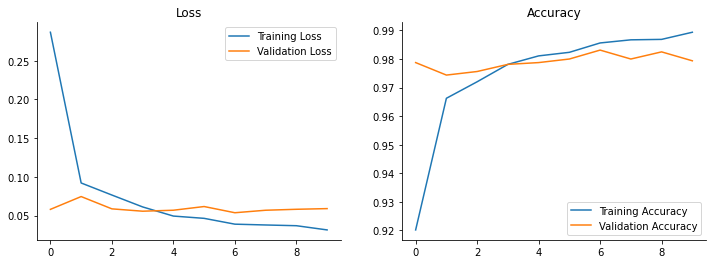

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

<a id="section-conc"></a>
# Conclusion

VGG16 Pre-Train Model is Implemented on Cat and Dog data set with 97% of accuracy and 5% of loss